Hi Daniel. Below is all of our code. Please bear in mind that becuase of the webcrawling for both the healthy and dessert recipes, the code takes a little bit of time to execute. I timed it and it took about 2 minutes and 30 seconds to execute. You can track the progress of the two webcrawling kernels using the print statments. Each will print "working" while it is crawling and then print "all done" when it is finished. 

Also, in our presentation we used the numbers/analytics generated by the dessert and healthy recipies that our webcrawler retrieved at the time we first ran the finished code (this means your numbers may differ slightly depending on what 50 recipies the webcrawler scrapes when you run it). 

In [10]:
#Helper Functions

In [11]:
#returns star review of a recipe
def get_star_review(websiteData):
    
    #regex string to extract the star value
    pattern = re.compile(r'"ratingValue":(\d+)')
    match = pattern.search(str(websiteData.content))   
    
    return match[1]

In [12]:
#returns a list of the text content of all the reviews for a recipe
def get_review_text(websiteData):
    
    all_reviews = []

    #regex string to extract user reviews of dish
    pattern = re.compile(r'"reviewBody":\s*"([^"]*)"') 
    matches = pattern.findall(str(websiteData.content)) 
    
    for match in matches:
        all_reviews.append(match)
    
    return all_reviews

In [13]:
#Getting Healthy Recipe Review Content

In [14]:
import requests

print("working")

#grabbing some healthy recipes off the healthy homepages to help out the webcrawler
healthyDinners = requests.get('https://cooking.nytimes.com/68861692-nyt-cooking/2110373-healthy-weeknight-dinners')
healthyBreakfast = requests.get('https://cooking.nytimes.com/68861692-nyt-cooking/16596-healthy-breakfast-ideas')
salads = requests.get('https://cooking.nytimes.com/68861692-nyt-cooking/807794-cheery-winter-salads-for-dreary-days')

working


In [15]:
import re

#extracting the recipe links from all the pages we loaded in for healthy

healthyRecipeLinks = []

#regex string to extract recipe links from the recipe webpages
pattern = re.compile(r'https://cooking\.nytimes\.com/recipes/([^"]*)')

healthyDinnerMatches = pattern.findall(str(healthyDinners.content)) 
healthyBreakfastMatches = pattern.findall(str(healthyBreakfast.content))
saladMatches = pattern.findall(str(salads.content))

#list of every link for healthy (not filtered for 5 stars yet)
allMatches = healthyDinnerMatches + saladMatches + healthyBreakfastMatches

#after this for loop healthyRecipeLinks is now a list of the links of all 5 star healthy recipes
for match in allMatches:
    link = "https://cooking.nytimes.com/recipes/" + match
    content = requests.get(link)
    if(get_star_review(content) == "5"):
        healthyRecipeLinks.append("https://cooking.nytimes.com/recipes/" + match)

#turning into a set gets rid of the duplicate links
healthyRecipesSet = set(healthyRecipeLinks)

print("all done")

all done


In [16]:
#webcrawler for healthy recipes 

firstHealthy = '/12900-roasted-beet-and-winter-squash-salad-with-walnuts' #webcrawler needs a link to start crawling on
healthyLinksTried = []
healthyLinks = list(healthyRecipesSet) #we start off the healthy links list with those we got from the healthy homepage

healthyCounter = 1

patternHealthy = re.compile('"keywords":"(?:[^"]*healthy[^"]*),') #regex string used to see if recipe is "healthy" by NYT Cooking standards
websitePattern = re.compile(r'href="/recipes/(.*?)"') #regex string to match all the website links on the recipe page

print("working")

#main webcrawling function for healthy
def healthyCrawl(link, counter):
    
    if link in healthyLinksTried:
        fullLink = link
    else:
        fullLink = "https://cooking.nytimes.com/recipes/" + link

    if fullLink not in healthyLinksTried:
        healthyLinksTried.append(fullLink)
    data = requests.get(fullLink)
    
    #if recipe is healthy and has the correct star rating
    if bool(patternHealthy.search(str(data.content))):
        if get_star_review(data) == "5" or get_star_review(data) == "4":
            match = patternHealthy.search(str(data.content))
            if fullLink not in healthyLinks:
                healthyLinks.append(fullLink)
    
    websiteMatches = websitePattern.findall(str(data.content))
        
    for match in websiteMatches:
        fullMatch = "https://cooking.nytimes.com/recipes/" + match
        if fullMatch not in healthyLinksTried:
            counter = 1
            return match + "," + str(counter)
        
    #if we have gotten to these if statements that means that every recipe link on the current page has been tried before
    #this begins the "backcrawling"
    
    #this if statement executes if the current link we are looking at is the first one we ever tried
    #ie. if this triggers that means we backcrawled through every link we have and we can't do anything else
    if fullLink == healthyLinksTried[0]:
        print("all links tried sorry")
        return "all links tried sorry,1"
    
    #otherwise we want to backcrawl to one recipe back from where we currenlty are in the list 
    else:
        counter = counter + 1
        stringCounter = str(counter)
        newIndex = -1 - counter
        return str(healthyLinksTried[newIndex]) + "," + stringCounter
    

currentLink = healthyCrawl(firstHealthy, healthyCounter)
currentCounter = 1

#runs the crawler but limits it to work until we get 50 recipe links in our list or run out of links to try
while len(healthyLinks) < 50 and currentLink != "all links tried sorry":
   
    newLinkandCounter = healthyCrawl(currentLink, currentCounter)
    splitUp = newLinkandCounter.split(",")
    newLink = splitUp[0]
    newCounter = splitUp[1]
    currentLink = newLink
    currentCounter = int(newCounter)
    
print("all done")        

working
all done


In [17]:
healthySet = set(healthyLinks) #gets rids of any duplicates just in case

#extract the reviews 
allHealthyReviews = []

for link in healthySet:
    content = requests.get(link)
    allHealthyReviews.extend(get_review_text(content))

In [18]:
#allHealthyReviews is final result ie. all reviews in one list
print("Total Healthy Recipes Used: " + str(len(healthySet)))
print("Total Healthy Reviews: " + str(len(allHealthyReviews)))

Total Healthy Recipes Used: 50
Total Healthy Reviews: 2626


In [19]:
#Getting Dessert Recipe Review Content

In [20]:
#web crawler for dessert 

#fewer comments throughout this block (see healthy webcrawler if any line is confusing)

firstDessert = '/1015819-chocolate-chip-cookies'
dessertLinksTried = []
dessertLinks = []

myCounter = 1


patternDessert = re.compile('recipeCategory":"dessert"')
websitePattern = re.compile(r'href="/recipes/(.*?)"')

print("working")

def doLinkStuffDessert(link, counter):
    
    if link in dessertLinksTried:
        fullLink = link
    else:
        fullLink = "https://cooking.nytimes.com/recipes/" + link
        
    if fullLink not in dessertLinksTried:
        dessertLinksTried.append(fullLink)
    data = requests.get(fullLink)
    
    
    if bool(patternDessert.search(str(data.content))):
        if get_star_review(data) == "5" or get_star_review(data) == "4":
            match = patternDessert.search(str(data.content))
            dessertLinks.append(fullLink)
    
    websiteMatches = websitePattern.findall(str(data.content))
        
    for match in websiteMatches:
        fullMatch = "https://cooking.nytimes.com/recipes/" + match
        if fullMatch not in dessertLinksTried:
            counter = 1
            return match + "," + str(counter)
    if fullLink == dessertLinksTried[0]:
        print("all links tried sorry")
        return "all links tried sorry,1"
    else:
        counter = counter + 1
        stringCounter = str(counter)
        newIndex = -1 - counter
        return str(dessertLinksTried[newIndex]) + "," + stringCounter
    

currentLink = doLinkStuffDessert(firstDessert, myCounter)
currentCounter = 1
while len(dessertLinks) < 50 and currentLink != "all links tried sorry":
    newLinkandCounter = doLinkStuffDessert(currentLink, currentCounter)
    splitUp = newLinkandCounter.split(",")
    newLink = splitUp[0]
    newCounter = splitUp[1]
    currentLink = newLink
    currentCounter = int(newCounter)

    
print("all done")

working
all done


In [21]:
#gets rids of any duplicates just in case
dessertLinksSet = set(dessertLinks) 

#extract the reviews
allDessertReviews = []

for link in dessertLinksSet:
    content = requests.get(link)
    allDessertReviews.extend(get_review_text(content))

In [22]:
#allDessertReviews is final result ie. all reviews in one list
print("Total Dessert Recipes Used: " + str(len(dessertLinksSet)))
print("Total Dessert Reviews: " + str(len(allDessertReviews)))

Total Dessert Recipes Used: 50
Total Dessert Reviews: 2838


In [23]:
#Analysis of all the reviews

Text(0.5, 1.0, 'Healthy')

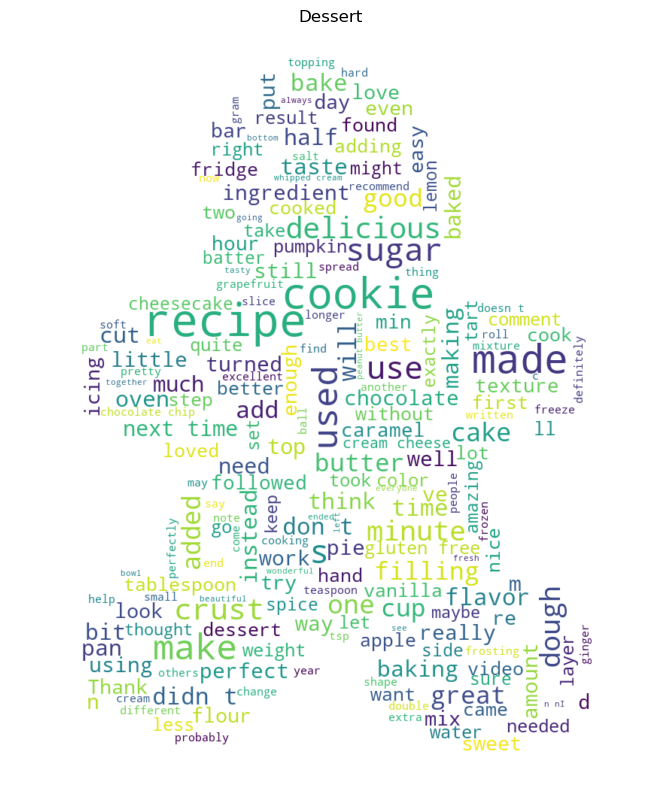

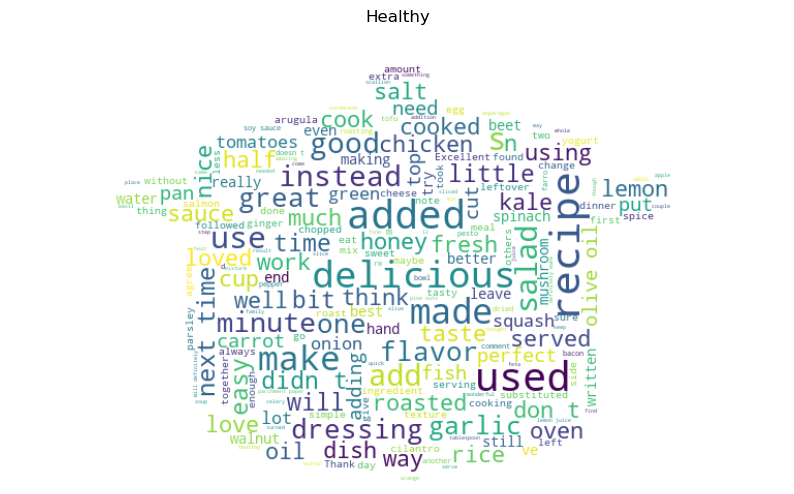

In [24]:
#Word Clouds 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from PIL import Image

dessertReviewString = ""
healthyReviewString = ""


for dessertReview in allDessertReviews:
    cleanedReview = dessertReview.replace("xe2", "").replace("x80", "").replace("x99", "").replace("x9d","")
    dessertReviewString += cleanedReview


for healthyReview in allHealthyReviews:
    cleanedReview = healthyReview.replace("xe2", "").replace("x80", "").replace("x99", "")
    healthyReviewString += cleanedReview
    
potImage = np.array(Image.open('pot.jpeg'))
cookieImage = np.array(Image.open('ginger5.jpeg'))


wordCloudDessert = WordCloud(max_font_size=60, mask = cookieImage, background_color='white').generate(dessertReviewString)
plt.figure(figsize=(10, 10))
plt.imshow(wordCloudDessert, interpolation="bilinear")
plt.axis("off")
plt.title("Dessert")

wordCloudHealthy = WordCloud(max_font_size=40, mask = potImage, background_color='white').generate(healthyReviewString)
plt.figure(figsize=(10, 10))
plt.imshow(wordCloudHealthy, interpolation="bilinear")
plt.axis("off")
plt.title("Healthy")



In [25]:
top10DessertWords = list(wordCloudDessert.words_.keys())[0:10]
print("Top 10 Most Common Words in Dessert Reviews:" + str(top10DessertWords))

top10HealthyWords = list(wordCloudHealthy.words_.keys())[0:10]
print("Top 10 Most Common Words in Healthy Reviews:" + str(top10HealthyWords))

Top 10 Most Common Words in Dessert Reviews:['recipe', 'cookie', 'made', 'make', 'used', 's', 'sugar', 'use', 'crust', 'delicious']
Top 10 Most Common Words in Dessert Reviews:['recipe', 'used', 'added', 'delicious', 'made', 'make', 's', 'use', 'add', 'salad']


In [28]:
#Sentiment Analysis
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/LizzieBlaschke/nltk_data...


In [29]:
sid_obj = SentimentIntensityAnalyzer()

#healthy reviews
healthyNeg = 0
healthyNeu = 0
healthyPos = 0

posH = []
negH = []
neuH = []

for reviewHealthy in allHealthyReviews:
    neg_neu_pos = sid_obj.polarity_scores(reviewHealthy)
    healthyNeg += neg_neu_pos["neg"]
    healthyNeu += neg_neu_pos["neu"]
    healthyPos += neg_neu_pos["pos"]
    
    negH.append(neg_neu_pos["neg"])
    neuH.append(neg_neu_pos["neu"])
    posH.append(neg_neu_pos["pos"])

#dessert reviews
dessertNeg = 0
dessertNeu = 0
dessertPos = 0

posD = []
negD = []
neuD = []

for reviewDessert in allDessertReviews:
    neg_neu_pos = sid_obj.polarity_scores(reviewDessert)
    dessertNeg += neg_neu_pos["neg"]
    dessertNeu += neg_neu_pos["neu"]
    dessertPos += neg_neu_pos["pos"]
    
    negD.append(neg_neu_pos["neg"])
    neuD.append(neg_neu_pos["neu"])
    posD.append(neg_neu_pos["pos"])


#results 

print("Healthy Reviews on average are " + str(round((healthyPos/len(allHealthyReviews) * 100),2)) 
      + "% positive, " + str(round((healthyNeu/len(allHealthyReviews) * 100),2)) + 
      "% neutral, and " + str(round((healthyNeg/len(allHealthyReviews) * 100),2)) + "% negative.")

print("Dessert Reviews on average are " + str(round((dessertPos/len(allDessertReviews) * 100),2)) 
      + "% positive, " + str(round((dessertNeu/len(allDessertReviews) * 100),2)) + 
      "% neutral, and " + str(round((dessertNeg/len(allDessertReviews) * 100),2)) + "% negative.")




Healthy Reviews on average are 17.47% positive, 79.87% neutral, and 2.67% negative.
Dessert Reviews on average are 14.99% positive, 81.74% neutral, and 3.27% negative.


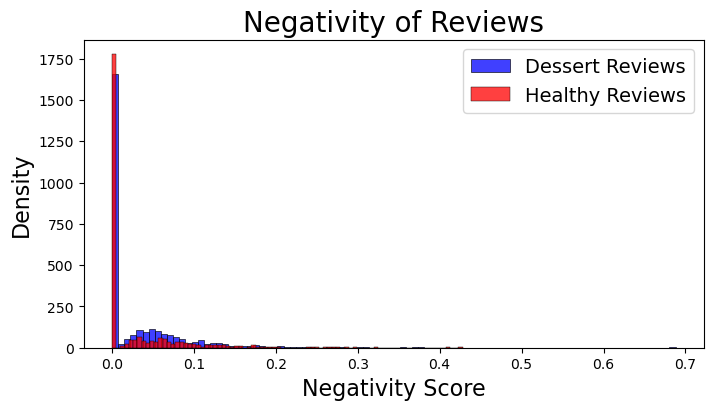

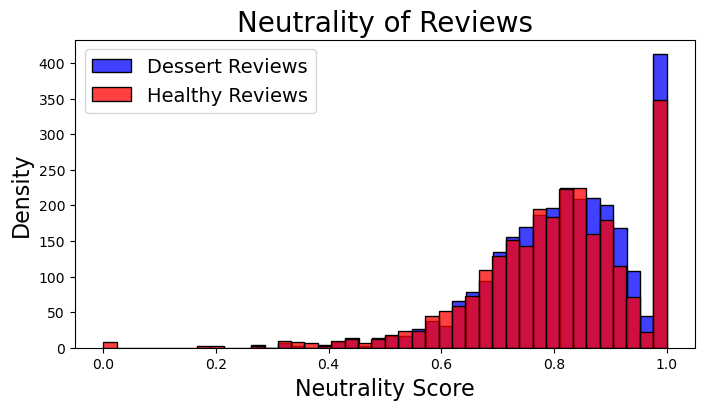

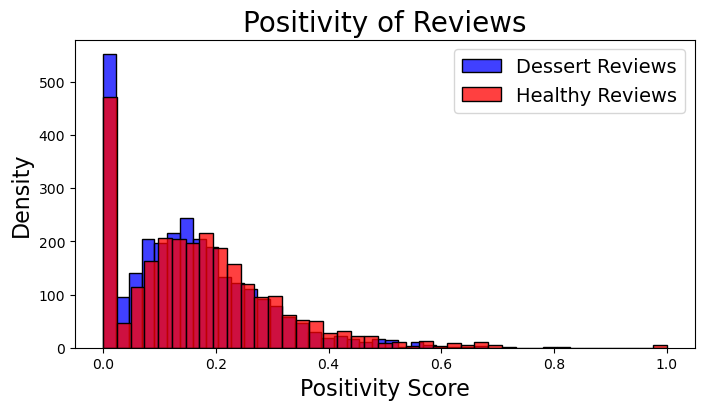

In [30]:
# Plotting histograms
import seaborn as sns

# Neg
plt.figure(figsize=(8, 4))
ax = sns.histplot(negD, label='Dessert Reviews', color='blue')
ax = sns.histplot(negH, label='Healthy Reviews', color='red')
ax.set_title('Negativity of Reviews', fontsize=20)
ax.set_ylabel('Density', fontsize=16)
ax.set_xlabel('Negativity Score', fontsize=16)
ax.legend(prop=dict(size=14))

#Neu
plt.figure(figsize=(8, 4))
ax = sns.histplot(neuD, label='Dessert Reviews', color='blue')
ax = sns.histplot(neuH, label='Healthy Reviews', color='red')
# setting label, title and legend
ax.set_title('Neutrality of Reviews', fontsize=20)
ax.set_ylabel('Density', fontsize=16)
ax.set_xlabel('Neutrality Score', fontsize=16)
ax.legend(prop=dict(size=14))

#Pos
plt.figure(figsize=(8, 4))
ax = sns.histplot(posD, label='Dessert Reviews', color='blue')
ax = sns.histplot(posH, label='Healthy Reviews', color='red')
# setting label, title and legend
ax.set_title('Positivity of Reviews', fontsize=20)
ax.set_ylabel('Density', fontsize=16)
ax.set_xlabel('Positivity Score', fontsize=16)
ax.legend(prop=dict(size=14))
